#### 各パッケージのインストール，データ，hyperparametersの読み込み

In [1]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time


CPU times: user 6 µs, sys: 7 µs, total: 13 µs
Wall time: 27.9 µs


In [2]:
# CSVファイルにデータを保存
filename_with_force = f'/home/kuno/my_project/VDP/VDP_analysis/generate_data/data/VDP_0.csv'

# CSVファイルを読み込む
data_loaded_with_force = pd.read_csv(filename_with_force)

# CSVから値を抽出してNumpy配列に格納
X = data_loaded_with_force[['x', 'y', 'P_shifted']].values

X.shape


(100000, 3)

### 7. Generative Modelのうち，外力のデータのみ実データで更新し続ける．

期待としては，X, Yの精度も上がるということである．

In [3]:
n,m = X.shape

from reservoirpy.datasets import to_forecasting


In [4]:
def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):
    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations) + seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    # `warming_inputs`のサイズを検証して調整します。
    if warming_inputs is not None and len(warming_inputs) > seed_timesteps:
        # `seed_timesteps`に合わせてサイズを調整
        warming_inputs = warming_inputs[:seed_timesteps]
        plt.plot(warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations) + seed_timesteps, np.abs(X_t - X_gen), label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup period")

    plt.legend()
    plt.show()


In [5]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
    readout = Ridge(ridge=ridge)

    return reservoir >> readout


In [6]:
N = 10000
iss = 0.10559236858500565
lr = 0.7072505111678798
seed = 3
ridge = 4.103903362369966e-06
sr = 0.6723917252819582
forecast = 1

train_len = 40000
start_time = 0
test_length = 20000
nb_generations = 10000

seed_timesteps = test_length 


In [7]:
esn = reset_esn()

X_train = X[start_time:start_time+train_len]
y_train = X[start_time+1 :start_time+train_len + 1]

X_test = X[start_time+train_len : start_time+train_len + seed_timesteps]
y_test = X[start_time+train_len + 1: start_time+train_len + seed_timesteps + 1]

X_evolve = X[start_time+train_len + seed_timesteps:]


In [8]:
esn = esn.fit(X_train, y_train)


In [9]:
warming_inputs = X_test

warming_out = esn.run(warming_inputs, reset=True)  # warmup
#warming_outはX_test[seed_timesteps]を近似する．

In [10]:
X_gen = np.zeros((nb_generations, m))
y = warming_out[-1] 
print(y.shape) 
y = y.reshape(1, -1) 
print(y.shape) #配列の形式は(n, m)の二次元配列にする必要があるので調整した


(3,)
(1, 3)


In [11]:
for t in range(nb_generations):  
    y[:, 2:3] = X_evolve[t, 2:3] #外力にあたる[:, 2:3]に実測値を代入する．
    y = esn(y) #ESNで1回=0.1ステップ先を予測する．
    X_gen[t, :] = y #配列に記録していく


In [12]:
X_t = X_evolve[: nb_generations]


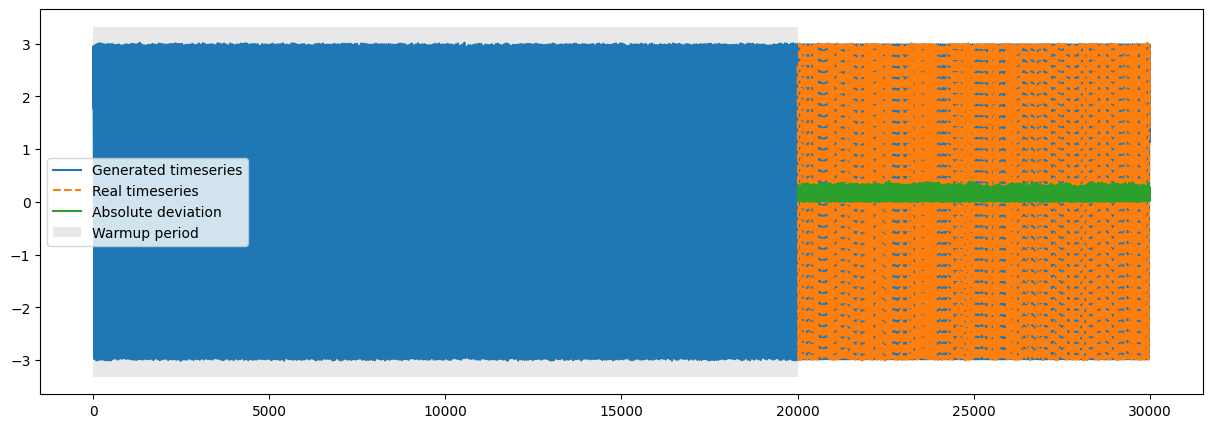

In [13]:
plot_generation(X_gen[:, :1], X_t[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)


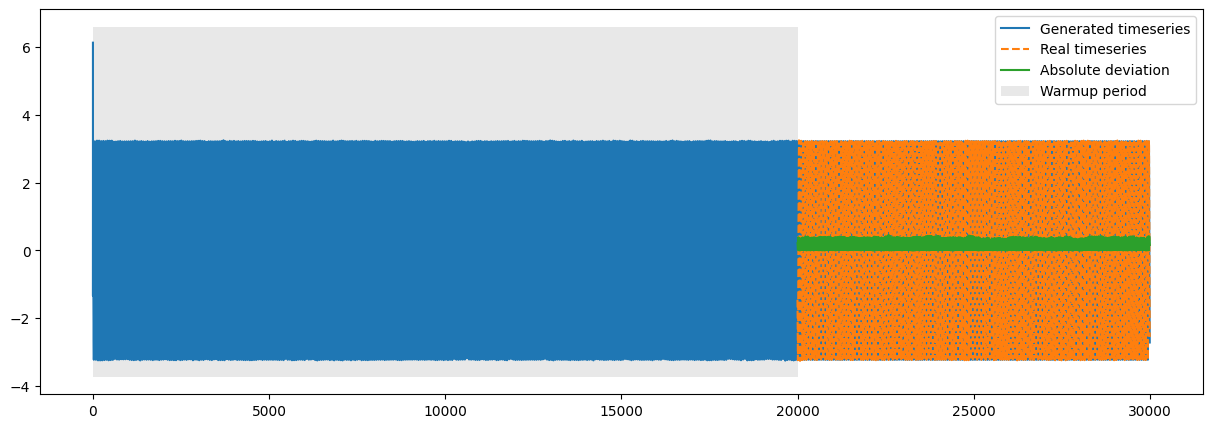

In [14]:
plot_generation(X_gen[:, 1:2], X_t[:, 1:2], nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)


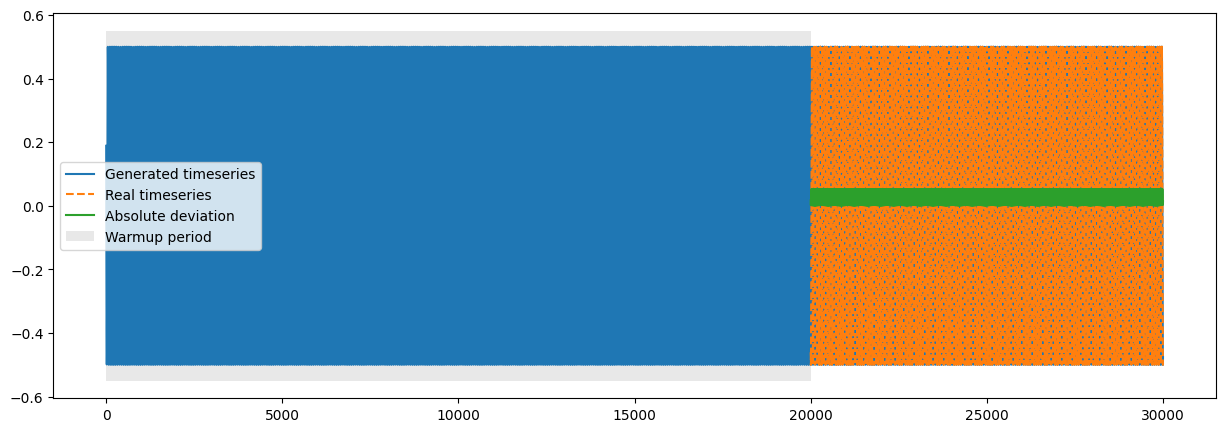

In [15]:
plot_generation(X_gen[:, 2:3], X_t[:, 2:3], nb_generations, warming_out=warming_out[:, 2:3],
                warming_inputs=warming_inputs[:, 2:3], seed_timesteps=seed_timesteps)


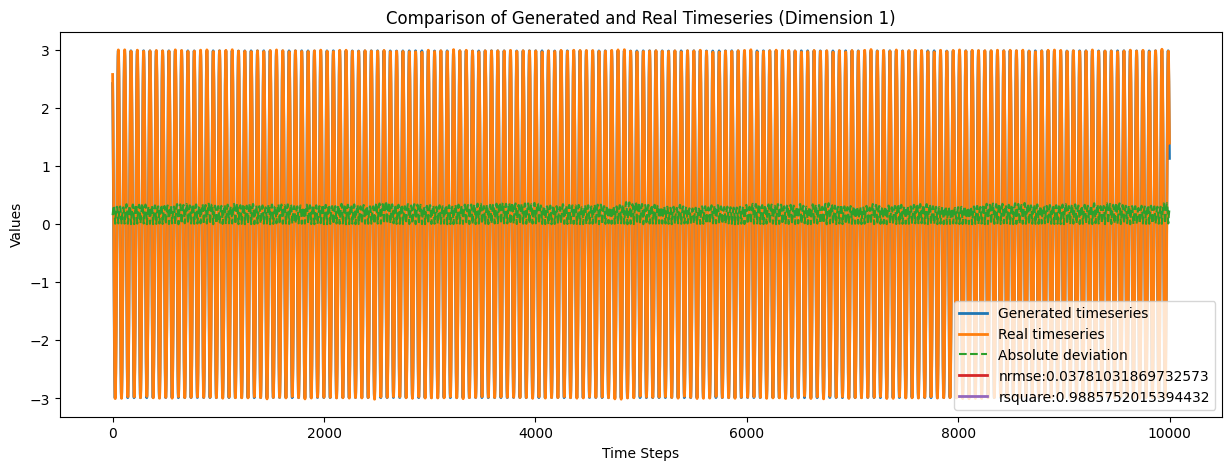

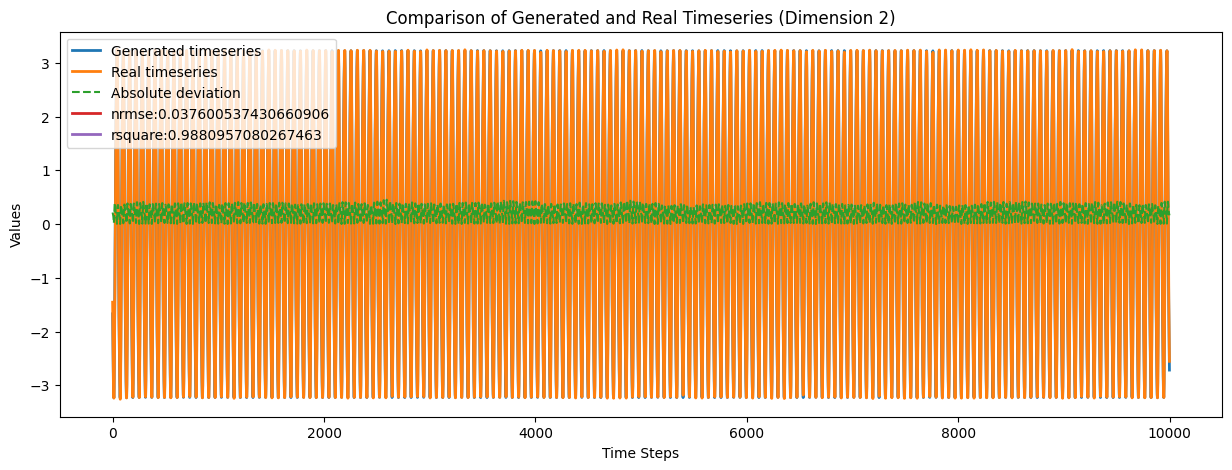

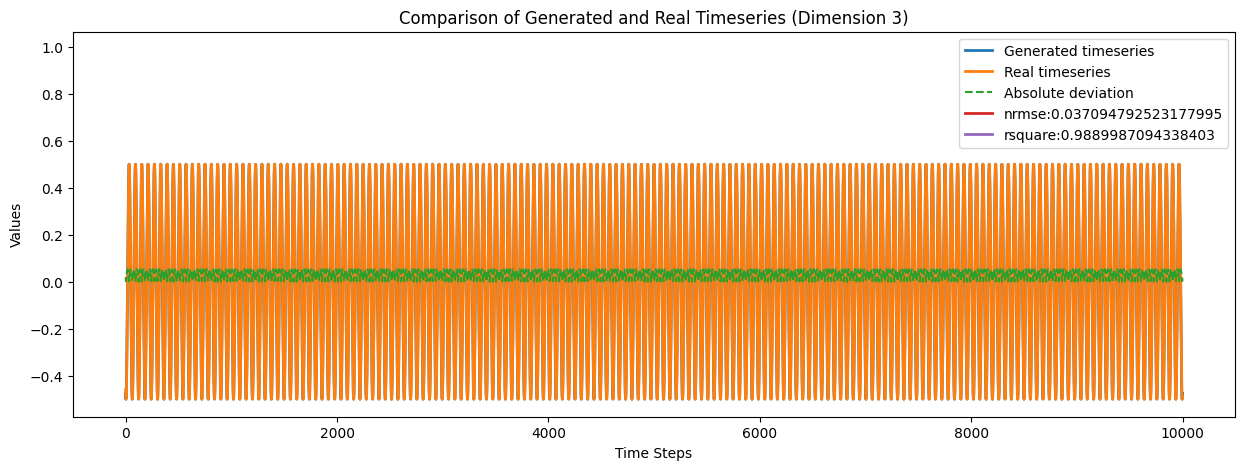

In [16]:
# 時系列データの比較を行う関数
def compare_timeseries_multidimensional(X_gen, X_t, nb_generations):
    num_dimensions = X_gen.shape[1]  # 次元数を取得
    for dim in range(num_dimensions):
        plt.figure(figsize=(15, 5))
        plt.plot(X_gen[:, dim][:nb_generations], label="Generated timeseries", linewidth=2)
        plt.plot(X_t[:, dim][:nb_generations], label="Real timeseries", linewidth=2)
        plt.plot(np.abs(X_t[:, dim][:nb_generations] - X_gen[:, dim][:nb_generations]), label="Absolute deviation", linestyle='--')
        plt.plot(nrmse(X_gen[:, dim][:nb_generations], X_t[:, dim][:nb_generations]), label=f"nrmse:{nrmse(X_gen[:, dim][:nb_generations], X_t[:, dim][:nb_generations])}", linewidth=2)
        plt.plot(rsquare(X_gen[:, dim][:nb_generations], X_t[:, dim][:nb_generations]), label=f"rsquare:{rsquare(X_gen[:, dim][:nb_generations], X_t[:, dim][:nb_generations])}", linewidth=2)

        plt.title(f'Comparison of Generated and Real Timeseries (Dimension {dim+1})')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.legend()        
        plt.show()

# 使用例:
compare_timeseries_multidimensional(X_gen, X_t, nb_generations)


In [41]:
# CSVファイルにデータを保存
filename_alt = f'/home/kuno/my_project/VDP/VDP_analysis/generate_data/data/VDP_7.csv'

# CSVファイルを読み込む
data_loaded_with_force = pd.read_csv(filename_alt)

# CSVから値を抽出してNumpy配列に格納
Y = data_loaded_with_force[['x', 'y', 'P_shifted']].values

Y.shape

(100000, 3)

In [42]:
warmp_up_length = 3000

In [43]:
Y_warmup = Y[start_time+train_len-warmp_up_length: start_time+train_len]

Y_evolve = Y[start_time+train_len + seed_timesteps:]


In [44]:
warming_inputs = Y_warmup

warming_out = esn.run(warming_inputs, reset=True)  # warmup
#warming_outはX_test[seed_timesteps]を近似する．

In [45]:
Y_gen = np.zeros((nb_generations, m))
y = warming_out[-1] 
print(y.shape) 
y = y.reshape(1, -1) 
print(y.shape) #配列の形式は(n, m)の二次元配列にする必要があるので調整した


(3,)
(1, 3)


In [46]:
for t in range(nb_generations):  
    y[:, 2:3] = Y_evolve[t, 2:3] #外力にあたる[:, 2:3]に実測値を代入する．
    y = esn(y) #ESNで1回=0.1ステップ先を予測する．
    Y_gen[t, :] = y #配列に記録していく


In [47]:
Y_t = Y_evolve[: nb_generations]


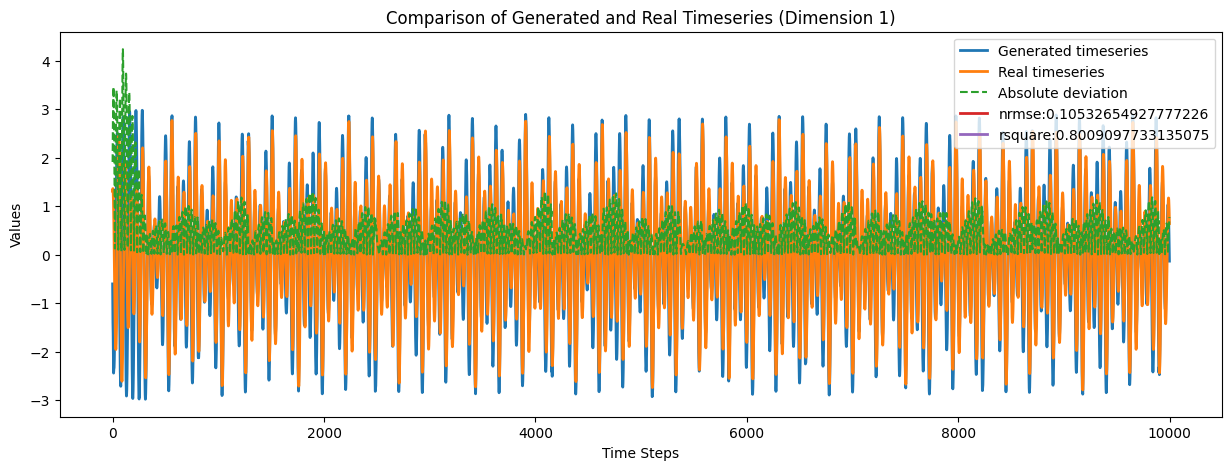

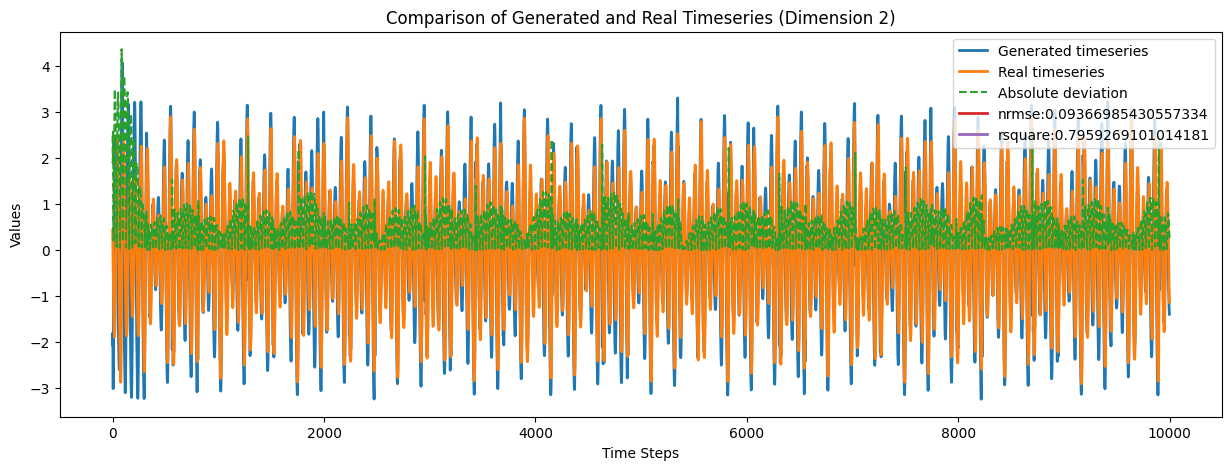

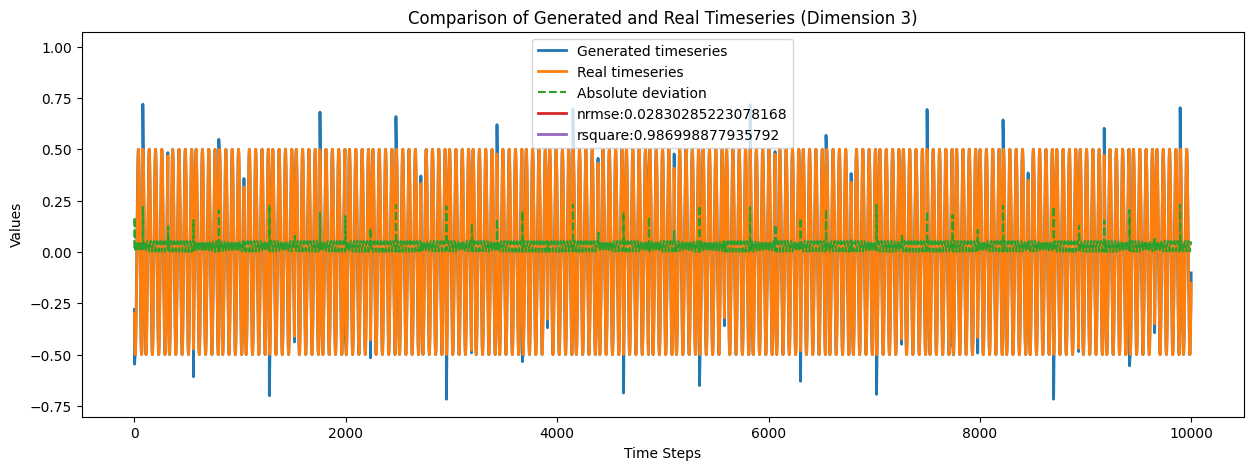

In [48]:
compare_timeseries_multidimensional(Y_gen, Y_t, nb_generations)

In [49]:
# CSVファイルにデータを保存
filename_alt = f'/home/kuno/my_project/VDP/VDP_analysis/generate_data/data/VDP_-7.csv'

# CSVファイルを読み込む
data_loaded_with_force = pd.read_csv(filename_alt)

# CSVから値を抽出してNumpy配列に格納
Y = data_loaded_with_force[['x', 'y', 'P_shifted']].values

Y.shape

(100000, 3)

In [50]:
warmp_up_length = 3000

In [51]:
Y_warmup = Y[start_time+train_len-warmp_up_length: start_time+train_len]

Y_evolve = Y[start_time+train_len + seed_timesteps:]


In [52]:
warming_inputs = Y_warmup

warming_out = esn.run(warming_inputs, reset=True)  # warmup
#warming_outはX_test[seed_timesteps]を近似する．

In [53]:
Y_gen = np.zeros((nb_generations, m))
y = warming_out[-1] 
print(y.shape) 
y = y.reshape(1, -1) 
print(y.shape) #配列の形式は(n, m)の二次元配列にする必要があるので調整した


(3,)
(1, 3)


In [54]:
for t in range(nb_generations):  
    y[:, 2:3] = Y_evolve[t, 2:3] #外力にあたる[:, 2:3]に実測値を代入する．
    y = esn(y) #ESNで1回=0.1ステップ先を予測する．
    Y_gen[t, :] = y #配列に記録していく


In [55]:
Y_t = Y_evolve[: nb_generations]


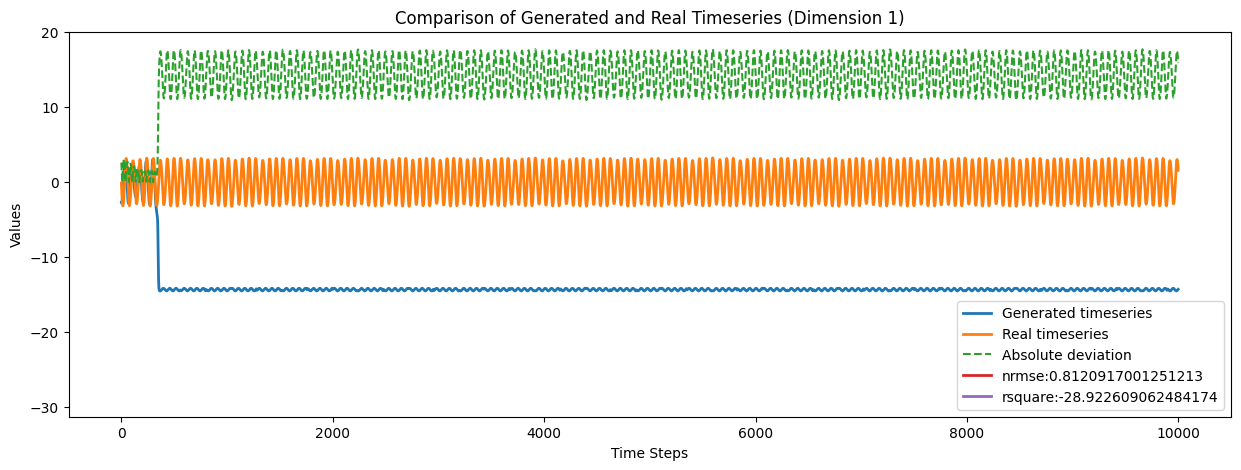

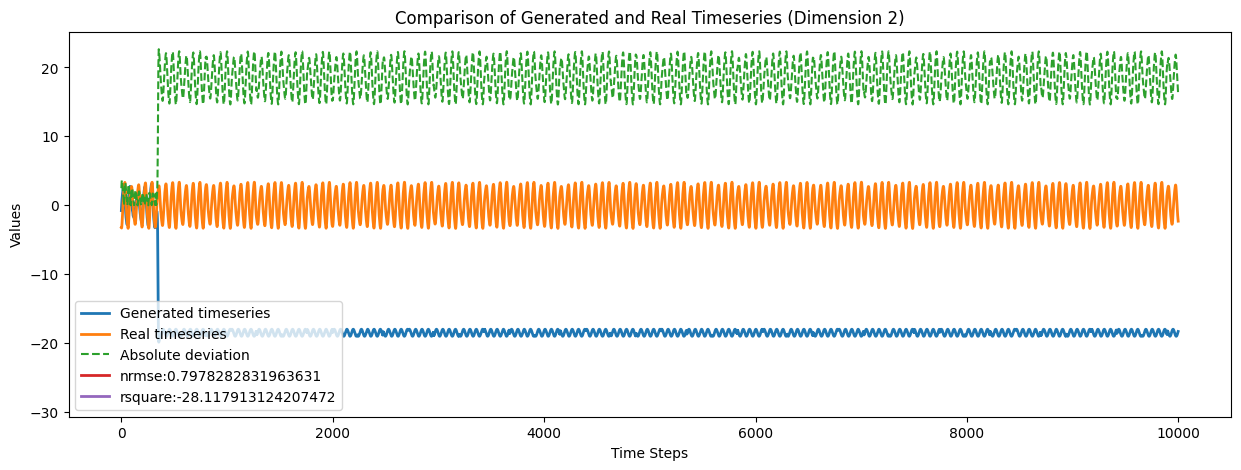

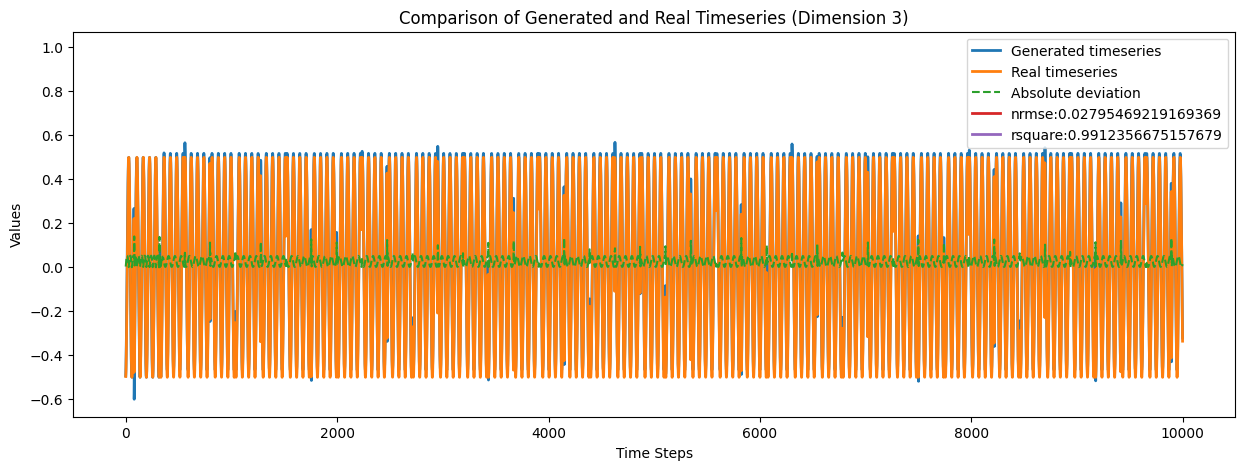

In [56]:
compare_timeseries_multidimensional(Y_gen, Y_t, nb_generations)

In [57]:
# CSVファイルにデータを保存
filename_alt = f'/home/kuno/my_project/VDP/VDP_analysis/0random/generate_data/data/VDP_random.csv'

# CSVファイルを読み込む
data_loaded_with_force = pd.read_csv(filename_alt)

# CSVから値を抽出してNumpy配列に格納
Y = data_loaded_with_force[['x', 'y', 'P_shifted']].values

Y.shape

(100000, 3)

In [58]:
warmp_up_length = 3000

In [59]:
Y_warmup = Y[start_time+train_len-warmp_up_length: start_time+train_len]

Y_evolve = Y[start_time+train_len + seed_timesteps:]


In [60]:
warming_inputs = Y_warmup

warming_out = esn.run(warming_inputs, reset=True)  # warmup
#warming_outはX_test[seed_timesteps]を近似する．

In [61]:
Y_gen = np.zeros((nb_generations, m))
y = warming_out[-1] 
print(y.shape) 
y = y.reshape(1, -1) 
print(y.shape) #配列の形式は(n, m)の二次元配列にする必要があるので調整した


(3,)
(1, 3)


In [62]:
for t in range(nb_generations):  
    y[:, 2:3] = Y_evolve[t, 2:3] #外力にあたる[:, 2:3]に実測値を代入する．
    y = esn(y) #ESNで1回=0.1ステップ先を予測する．
    Y_gen[t, :] = y #配列に記録していく


In [63]:
Y_t = Y_evolve[: nb_generations]


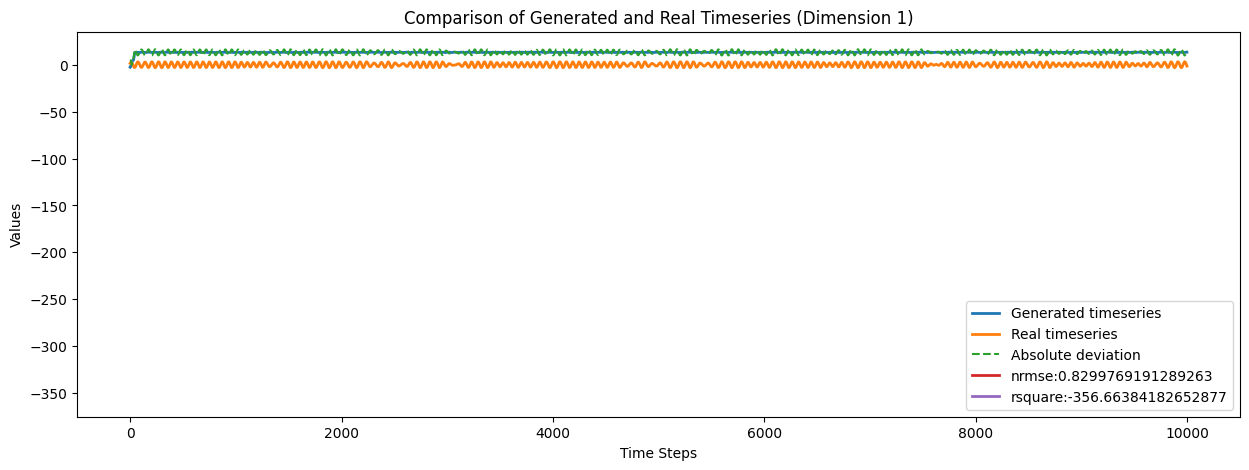

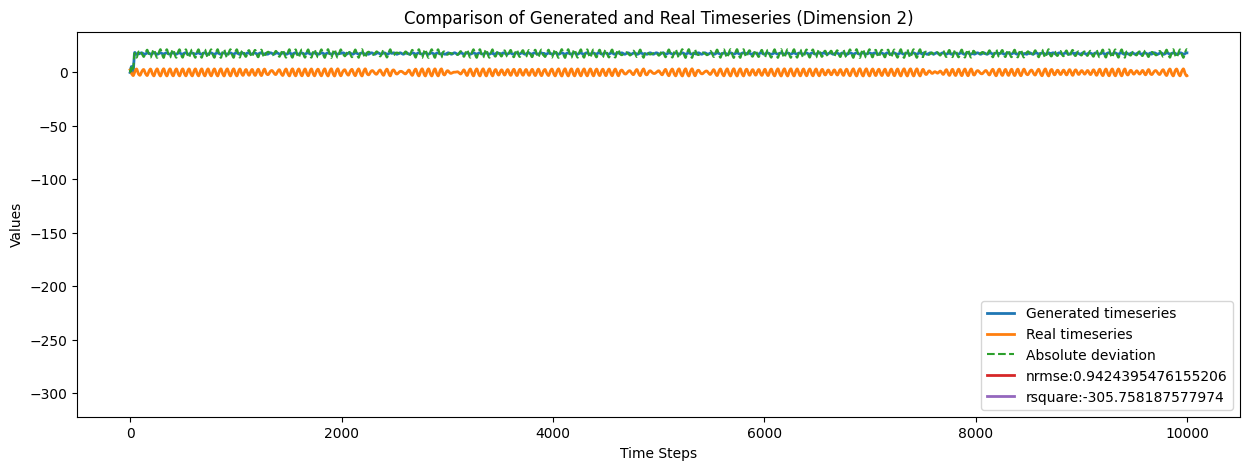

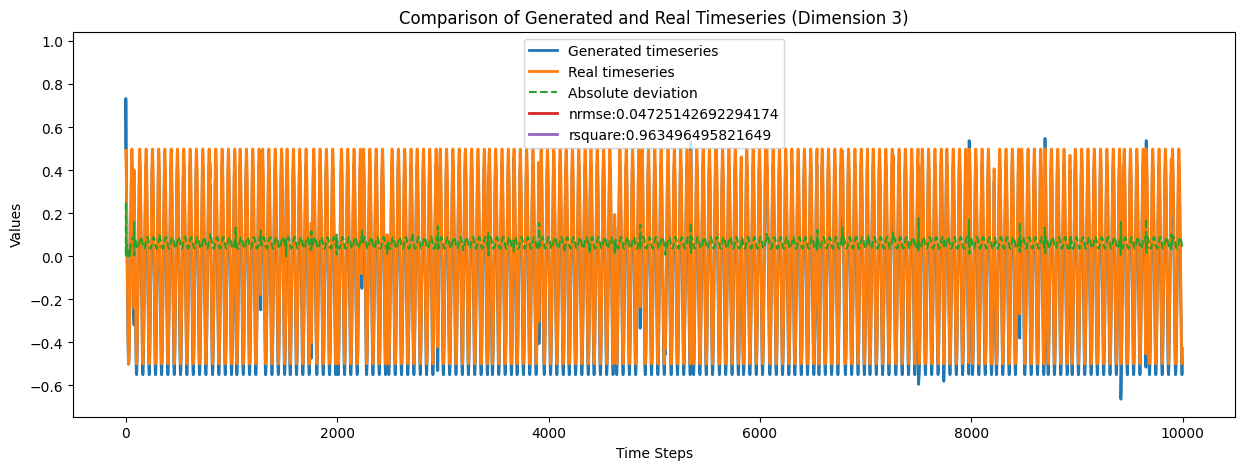

In [64]:
compare_timeseries_multidimensional(Y_gen, Y_t, nb_generations)